# Philo
-------------------------------------------------------------
A small-scale cold gas VTVL rocket

In [62]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


The goal of this notebook is to outline the process for determining the optimal engine parameters for a cold gas VTVL rocket engine. Rather than spending time and money iterating through different vehicle designs, we first do some math to find the optimal parameters (ie - chamber pressure and temp, nozzle charactertics, etc) for our vehicle. It's important to keep in mind that the values we generate have to be realistic and reasonable. Once we have ballpark parameters, we can evaluate and tune them to match existing COTS parts, and if necessary, fabricate custom ones.

### Assumptions
1. Isentropic Process
2. Choked flow, Ma = 1 at the throat of the nozzle (proof: [link here])}
3. Pb = 101.325kPa (Ambient Pressure)
4. Tb = 298.15K (Ambient Temperature)

### Initial Vehicle Model
1. Engine throat is the exit nozzle
2. Propellant: Air, cp = 0.846, cv = 0.657, gamma = 1.28
3. Dry mass        = 1.89kg
4. Propellant mass = 0.53kg

In [63]:
# Environment Properties
P_atm = 101325           # Pa (Ambient Pressure)
T_atm = 298.15           # K (Ambient Temperature)
T_o = 298.15             # K (Tank Temperature)
R = 8.314                # J/(K*mol)
g = 9.81                 # m/s^2
Ma_t = 1                 # Mach (at throat)

# Propellant Properties 
cp = 1.005               # Constant pressure specific heat
cv = 0.718               # Constant volume specific heat
molar_mass = 0.02897     # kg/mol
gamma = cp/cv            # Specific Heat Ratio

# Vehicle Properties
dry_mass = 1.89                     # kg (rough estimation based on current design)
prop_mass = 0.53                    # kg (based on tank capacity and gas)
wet_mass = dry_mass + prop_mass     # kg

#### Step 0: Determine Theoretical Maximum Flight Time

This will be driven by our initial assumptions and initial vehicle model. With these parameters we can determine the theoretical maximum flight time using the rocket equation and by dividing the delta_V by gravity vector:

\begin{equation}
V_\Delta = V_e * ln\left(\frac{m_o}{m_f} \right)
\end{equation}

Where V_e_expected = 1000m/s 
(Based on Figure 2-5 from RPE - https://www.ewp.rpi.edu/hartford/~ernesto/S2013/EP/MaterialsforStudents/Lee/Sutton-Biblarz-Rocket_Propulsion_Elements.pdf)

In [64]:
v_e_expected = 1100   # m/s (APPROXIMATION)

delta_v = v_e_expected * np.log(wet_mass/dry_mass)

print ("Delta V: %0.2f m/s" % delta_v)

Delta V: 271.91 m/s


Divide by gravity vector to obtain flight time:

In [65]:
t_theoretical = delta_v / g

print ("Theoretical Flight Time: %0.2f sec" % t_theoretical)

Theoretical Flight Time: 27.72 sec



#### Step 1: Determine Choked Flow Parameters
Determine choked flow parameters:
> <b>KEY CONCEPTS: </b>
> * At choked flow, mass flow rate is <b>constant</b>
> * A converging section is required to achieve choked flow
> * A diverging section in the nozzle is required for exceeding sonic speeds at the exit of the nozzle 
> * Since choked flow occurs at the throat of the nozzle, we base our equations relative to this plane. 
> * Choked flow occurs when the chamber pressure and temperature (stagnation pressure and temperature) reach their critical values.
> * To determine these critical values, we must use the critical ratios (a property of the propellant).
> * Thus choked flow is achieved when the chamber pressure (P_o) is greater than or equal to the critical pressure (P_*), and the chamber temperature (T_o) is greater than or equal to the critical temperature (T_*) respectively.

TODO: ADD diagrams here showing the characteristics of coverging and diverging nozzles and how they interact with flow at subsonic, sonic, and supersonic conditions

 Find the minimum chamber pressure (P_o) required to achieve choked flow and add margin 
 > Margin is added to compensate for regulator lag and to keep us safely in the choked flow region. If we break out of choked flow, our constant mass flow assumption no longer holds true, making the math much more complicated.

Plot the Area ratio equation to demonstrate why we need a converging/diverging nozzle.

\begin{equation}
\frac{A}{A_*} = \frac{1}{Ma}\left[ \frac{1+\frac{\gamma-1}{2}Ma^2}{1+\frac{\gamma-1}{2}} \right]^\frac{\gamma+1}{2(\gamma-1)}
\end{equation}

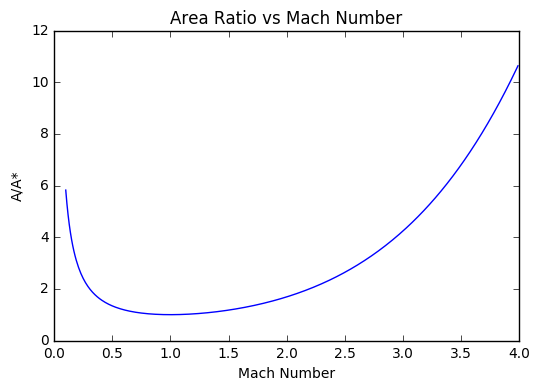

In [66]:
def area_ratio(Ma):
    
    A_ratio = (1/Ma)*(((1+((gamma-1)/2)*(Ma**2))/(1+((gamma-1)/2)))**((gamma+1)/(2*(gamma-1))))
    
    return A_ratio

ma_array = np.arange(0.1, 4, 0.01)
A_array = area_ratio(ma_array)

plt.figure(1)
plt.xlabel('Mach Number')
plt.ylabel('A/A*')
plt.title('Area Ratio vs Mach Number')
plt.plot(ma_array, A_array)
plt.show()

Notice how the ratio decreases as we increase the Mach number. We reach a minimum at Ma=1 where by after, the area ratio begins to increase.

\begin{equation}
\frac{P_o}{P} = \left[1+\left(\frac{\gamma-1}{2}\right)Ma^2\right]^\frac{\gamma}{\gamma-1}
\end{equation}

\begin{equation}
\frac{T_o}{T} = 1+\left(\frac{\gamma-1}{2}\right)Ma^2
\end{equation}

\begin{equation}
\frac{\rho_o}{\rho} = \left[1+\left(\frac{\gamma-1}{2}\right)Ma^2\right]^\frac{1}{\gamma-1}
\end{equation}

\begin{equation}
M_a = \sqrt{\frac{2}{\gamma-1}\left(\left(\frac{P_o}{P}\right)^{\frac{\gamma-1}{\gamma}} - 1\right)}
\end{equation}

Calculating at the throat where Ma = 1, we can now find the critical pressure and temperature:

\begin{equation}
\frac{P_o}{P_*} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{\gamma}{\gamma-1}
\end{equation}

\begin{equation}
\frac{T_o}{T_*} = 1+\left(\frac{\gamma-1}{2}\right)
\end{equation}

\begin{equation}
\frac{\rho_o}{\rho_*} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{1}{\gamma-1}
\end{equation}

Since we know the flow is choked when the critical pressure (P_*) equals the back pressure (P_b), we can determine the minimum chamber pressure:

\begin{equation}
\frac{P_o}{P_b} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{\gamma}{\gamma-1}
\end{equation}

\begin{equation}
\frac{T_o}{T_b} = 1+\left(\frac{\gamma-1}{2}\right)
\end{equation}

\begin{equation}
\frac{\rho_o}{\rho_b} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{1}{\gamma-1}
\end{equation}

In [67]:
# Chamber Properties

# Assuming 'Throat = Exit' (converging nozzle only)

Ma_t = 1.0
P_b = P_atm

P_o = P_b*(((1+((gamma-1)/2)*(Ma_t**2))**(gamma/(gamma-1))))
T_b = T_o/(1+(((gamma-1)/2)*(Ma_t)))

P_o_min = P_o

print ("Choked Flow:")
print ("Ma_t: %.2f" % Ma_t)
print ("Given Exit/Throat Pressure: %.2f Pa" % P_b)
print ("Calculated Chamber Pressure: %.2f Pa" % P_o)
print ("Given Chamber Temperature: %.2f K" % T_o)
print ("Calculated Exit/Throat Temperature: %.2f K" % T_b)
print ("---------------------------------------")

Choked Flow:
Ma_t: 1.00
Given Exit/Throat Pressure: 101325.00 Pa
Calculated Chamber Pressure: 191784.01 Pa
Given Chamber Temperature: 298.15 K
Calculated Exit/Throat Temperature: 248.49 K
---------------------------------------


Recall, a converging nozzle can only ever achieve an exhaust velocity of Ma=1. So in order to optimize our specific impulse, we must now add a diverging section at the end.

#### Step 2: Determine Exit Velocity at Throat

Now that we know the the minimum chamber pressure and temperature, we can calculate the expected minimum exit velocity at the nozzle (V_e_min) using the following equation:

TODO: Write a set of equations (including density) going from chamber to throat, then later, throat to exit to show increase in v_e/efficiency 

\begin{equation}
c = \sqrt{\frac{\gamma R T}{m_{molar}}}
\end{equation}

\begin{equation}
M_a = \sqrt{\frac{2}{\gamma-1}\left( \left(\frac{P_o}{P_b}\right)^{\frac{\gamma-1}{\gamma}} - 1 \right)}
\end{equation}

\begin{equation}
V = M_ac
\end{equation}

Combined:

\begin{equation}
V = \sqrt{\frac{T_b R}{m_{molar}}*\frac{2 \gamma}{\gamma-1}*\left(\left(\frac{P_o}{P_b}\right)^{\frac{\gamma-1}{\gamma}}-1\right)}
\end{equation}

In [68]:
V_th = np.sqrt(((T_b * R) / molar_mass) \
      * ((2 * gamma) / (gamma - 1)) \
      * ((P_o / P_b) ** (
        (gamma - 1) / gamma)) -1 )

Isp = V_th / g

print ("Throat Velocity: %.2f m/s" % V_th)
print ("Specific Impulse (throat only): %2f sec" % Isp)

Throat Velocity: 774.11 m/s
Specific Impulse (throat only): 78.910697 sec


#### Step 3: Determine Cross-Sectional Area at the Throat of the Nozzle

Next we need to determine the cross-sectional area of the throat. However, before we proceed, we must first select our desired nominal thrust then solve for the mass flow rate using the following equation:

\begin{equation}
F = \dot{m}*V_{th}
\end{equation}

Rewritten as:

\begin{equation}
\dot{m} = \frac{F}{V_{th}}
\end{equation}

In order to determine the desired nominal thrust, we must calcuate the force necessary to null out the acceleration of a fully loaded rocket:

\begin{equation}
F_{nominal} = m_{wet} * g
\end{equation}

Of course, this force will change as the rocket loses mass, but it gives us a place to start.

In [69]:
F_nom = wet_mass * g

print ("Nominal Engine Thrust: %.2f N" % F_nom)

Nominal Engine Thrust: 23.74 N


With a nominal thrust, we can now work out a rough cross-sectional area at the throat.

In [70]:
mass_flow = F_nom / V_th         # kg/s

print ("Mass Flow Rate: %.6f kg/s" % mass_flow)

Mass Flow Rate: 0.030668 kg/s


With a known mass flow rate, we can now determine the cross-sectional area at the throat using the following equation:

CHECK THIS EQUATION

\begin{equation}
A_e = \frac{\dot{m}* \frac{R T_e}{m_{molar}} }{V_e P_e}
\end{equation}

\begin{equation}
A_e = \frac{\dot{m}* \left(1+(\gamma-1)\frac{Ma_e^2}{2}\right)^\frac{\gamma+1}{2(\gamma-1)}}{Ma_e P_e\sqrt{\frac{\gamma * m_{molar}}{R T_e}}}
\end{equation}

Since we are solving for the area at the throat of the nozzle: \begin{equation} M_a = 1 \end{equation}

In [71]:
P_e = P_b
T_e = T_b

A_e = (mass_flow*(1+(gamma-1)*((Ma_t**2)/2))**((gamma+1)/(2*(gamma-1))))/(Ma_t*P_o*np.sqrt((molar_mass*gamma)/(R*T_o)))

print ("Cross-sectional Area at Exit: %.8f m^2" % A_e)
print ("Cross-sectional Area at Exit: %.2f mm^2" % (A_e*1e6))

print ("Exit Diameter: %.2f mm" % (2*(np.sqrt((A_e*1e6)/np.pi))) )

Cross-sectional Area at Exit: 0.00006832 m^2
Cross-sectional Area at Exit: 68.32 mm^2
Exit Diameter: 9.33 mm


#### Step 4: Determine Flight Time

We can now obtain a ballpark estimate of flight time by dividing the total propellant mass by mass flow rate

\begin{equation}
t_{flight} = \frac{m_{prop}}{\dot{m}}
\end{equation}

In [72]:
t_flight = prop_mass / mass_flow    # sec

print ("Time of Flight: %0.2f sec" % t_flight)

Time of Flight: 17.28 sec


#### Step 5: Optimize for Flight Time

Not a very impressive flight time, but now we have a starting point, and there's plenty of room to optimize...

Now that we know the minimum values for choked flow while producing the necessary force to null out vertical acceleration of the vehicle, we can figure out which knobs to tune to optimize for flight time while checking/validating that we are still at choked flow. 
<br><br>
Flight time optimization goals:
1. Increase P_o to increase V_e and decrease mass flow rate and A thus increasing flight time.
3. Optimization shall check choke flow model for compliance
<br><br>

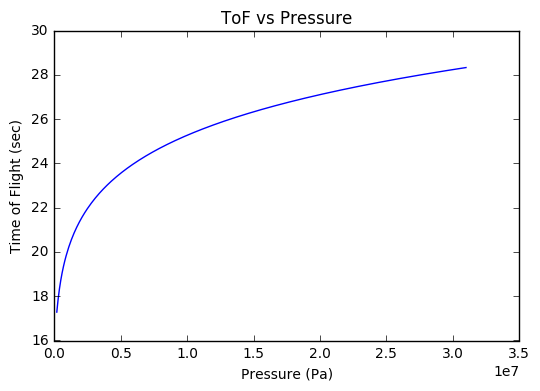

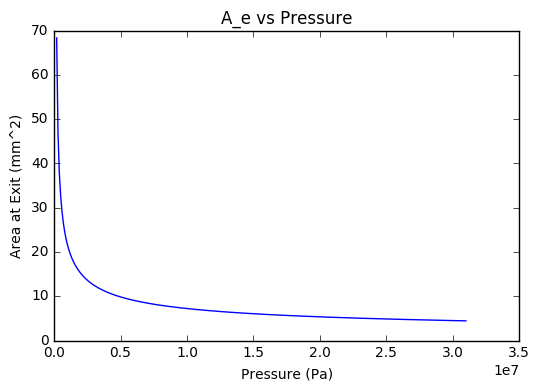

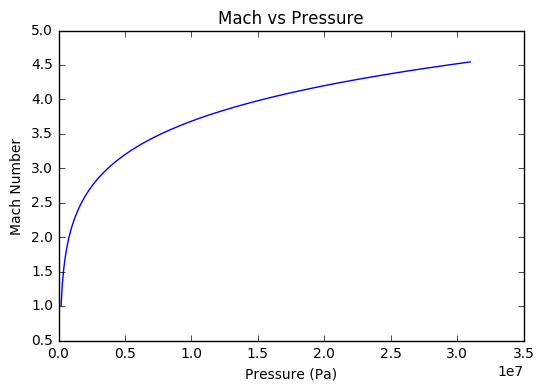

In [82]:
# Time of Flight vs Chamber Pressure

def calc_engine(P_o):    
    Ma_e = np.sqrt((2 / (gamma - 1)) \
      * (((P_o / P_b) ** (           \
        (gamma - 1) / gamma))-1))  
    
    T_b = T_o/(1+(((gamma-1)/2)*(Ma_e)))

    V_e = np.sqrt(((T_b * R) / molar_mass) \
      * ((2 * gamma) / (gamma - 1)) \
      * ((P_o / P_b) ** (       \
        (gamma - 1) / gamma))-1)

    Isp = V_e / g
    
    F_nom = wet_mass * g    
    
    mass_flow = F_nom / V_e             # kg/s    
    
    A_e = (mass_flow*(1+(gamma-1)*((Ma_e**2)/2))**((gamma+1)/(2*(gamma-1))))/(Ma_e*P_o*np.sqrt((molar_mass*gamma)/(R*T_o)))
    
    t_flight = prop_mass / mass_flow    # sec
    
    return t_flight, A_e, Ma_e

# p_o_min calculated above
p_step = 100000
P_tank_max = 3.1026e+7

# Sweep the pressure and plot the time of flight
p_array = np.arange(int(P_o_min), int(P_tank_max), p_step)
ToF_array, Ae_array, Mae_array = calc_engine(p_array)
Ae_array *= 1e6     # Convert from m^2 to mm^2

plt.figure(1)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Time of Flight (sec)')
plt.title('ToF vs Pressure')
plt.plot(p_array, ToF_array)

plt.figure(2)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Area at Exit (mm^2)')
plt.title('A_e vs Pressure')
plt.plot(p_array, Ae_array)
plt.show()

plt.figure(2)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Mach Number')
plt.title('Mach vs Pressure')
plt.plot(p_array, Mae_array)
plt.show()

As expected, we asymptote near a theoretical ToF limit near 16-17 seconds

Why is this not value not 25 seconds? <br>
Because we initially guessed a V_e limit of 1000 m/s based on a reference table, these results more accurately reflect the expected time of flight based on our vehicle model. However, our results are in family with the reference materal, so we can feel a little more confident with them.

Here's yet another step where the engineer gets to decide a value.. what nominal chamber pressure shall we go with?

First lets analyze what this graph is telling us:
> - As pressure increases, time of flight increases
> - We observe larger variations in time of flight as a function of error in pressure at lower pressures
> - At higher pressures, the gains in time of flight are very small

What we know about the real world and our rocket:
> - The higher the pressure, the more mass and complexity there is for measuring and controlling it
> - Tooling limitations: We can only make the throat of the nozzle so small
> - Mass is our enemy: The more mass we can shed, the greater our flight time

In [80]:
# Pick P_o, A_t, Time of Flight
P_o = 0.1e7 # Pa (~145psi) [TODO: EXPLAIN THIS CHOICE]

ToF, A_e = calc_engine(P_o)

print ("Chamber Pressure: %.2f Pa" % P_o)
print ("Selected ToF: %0.2f sec" % ToF)
print ("Selected A_e: %0.8f m^2" % A_e)
print ("Selected A_e: %.2f mm^2" % (A_e*1e6))
print ("Selected Exit Diameter: %.2f mm" % (2*(np.sqrt((A_e*1e6)/np.pi))) )

Chamber Pressure: 1000000.00 Pa
Selected ToF: 20.04 sec
Selected A_e: 0.00002165 m^2
Selected A_e: 21.65 mm^2
Selected Exit Diameter: 5.25 mm


Select desired exit velocity: M_e (in mach)

In [77]:
# Desired Exit Velocity (in Mach)
Ma_e = 4 # This isn't right, update

#### Step 6: Further Optimize by Adding an Exit Nozzle

Up until this point we've been assuming that the throat is the exit nozzle. The next step is to add an expansion at the end of the throat to maximize V_e (as per De Laval). The key to this is determining the desired area at the throat (see above) and calculating the area at the exit of the nozzle. Thankfully, this math isn't too bad. The Ae/At ratio is a direct function of the propellant chemical properties:

CHECK THESE EQUATIONS

\begin{equation}
\frac{A_e}{A_t} = \frac{1}{M_e}\left[ \left(\frac{2}{\gamma+1}\right)\left(1 + \frac{\gamma-1}{2}M_e^2\right) \right]^\frac{\gamma+1}{2(\gamma-1)}
\end{equation}

Since we already know A_t, we can now solve for A_e:

\begin{equation}
A_t = A_e M_e\left[ \left(\frac{2}{\gamma+1}\right)\left(1 + \frac{\gamma-1}{2}M_e^2\right) \right]^\frac{-\gamma+1}{2(\gamma-1)}
\end{equation}

In [78]:
print ("Exit Mach: %.2f\n" % Ma_e)

A_t = (A_e*Ma_e)*(((2/(gamma+1))*(1+((gamma-1)/2)*(Ma_e**2)))**((-(gamma+1))/(2*(gamma-1))))

print ("Area at Throat: %0.8f m^2" % A_t)
print ("Area at Throat: %.2f mm^2" % (A_t*1e6))
print ("Selected Throat Diameter: %.2f mm \n" % (2*(np.sqrt((A_t*1e6)/np.pi))) )

print ("Area at Exit: %0.8f m^2" % A_e)
print ("Area at Exit: %.2f mm^2" % (A_e*1e6))
print ("Selected Exit Diameter: %.2f mm \n" % (2*(np.sqrt((A_e*1e6)/np.pi))) )

# Ae/At Ratio
A_e_A_t = A_e / A_t
print ("Ae/At Ratio: %0.2f" % A_e_A_t)

Exit Mach: 4.00

Area at Throat: 0.00000202 m^2
Area at Throat: 2.02 mm^2
Selected Throat Diameter: 1.60 mm 

Area at Exit: 0.00002165 m^2
Area at Exit: 21.65 mm^2
Selected Exit Diameter: 5.25 mm 

Ae/At Ratio: 10.73


TODO: Recalculte ToF based on new V_e<br>
TODO: Include \begin{equation} F = \dot{m}*V_e + A_e(P_e - P_{atm}) \end{equation}

In [43]:
# Equation Pool
#V_e = Ma_t*np.sqrt((gamma*R*T_b)/molar_mass)
#P_b = P_o/(((1+((gamma-1)/2)*(Ma_t**2))**(gamma/(gamma-1))))
#Ma_t = np.sqrt((2 / (gamma - 1)) \
#      * (((P_o / P_b) ** (
#        (gamma - 1) / gamma))-1))